#  ¿Afecta la Luna a los Accidentes?
## Un tutorial de Regresión Binomial Negativa con Definiciones Formales

¡Bienvenido! En este cuaderno, vamos a investigar una pregunta clásica: ¿existe una relación real entre las fases de la luna y el número de accidentes?

Para hacerlo, usaremos un modelo estadístico profesional: la **Regresión Binomial Negativa (NB)**.

### Conceptos Clave de Inicio

1.  **Datos de Conteo (Count Data):** Es un tipo de variable que solo puede tomar valores enteros no negativos (0, 1, 2, 3...). Representa un conteo de eventos, como el número de accidentes por día, el número de clientes en una tienda, o el número de células en una muestra. No podemos usar una regresión lineal simple porque podría predecir valores sin sentido (ej. -4 accidentes).

2.  **Regresión Binomial Negativa (NB):** Es un **Modelo Lineal Generalizado (GLM)** diseñado específicamente para datos de conteo. Es una extensión del modelo de Poisson, pero con una ventaja clave: puede manejar la **sobredispersión**.

3.  **Sobredispersión (Overdispersion):** Es un fenómeno estadístico donde la **varianza** (la medida de dispersión o "caos") de los datos es significativamente mayor que su **media** (el promedio). Un modelo de Poisson asume que `Varianza ≈ Media`. En el mundo real, los accidentes son "agrupados" (un día de lluvia causa muchos), por lo que casi siempre `Varianza > Media`. El modelo NB está diseñado para esta situación.

In [2]:
# --- Paso 1: Importar las librerías ---
# Estas son las herramientas que usaremos

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Configuramos un estilo bonito para los gráficos
plt.style.use('ggplot')

## Paso 2: Generar Datos Sintéticos (Nuestro Laboratorio)

Crearemos nuestros propios datos *sintéticos* (falsos) donde *sabemos* la respuesta de antemano. Vamos a "cocinar" los datos con dos tipos de variables:

1.  **Nuestra variable de interés:** Un pequeño efecto para la "Luna Llena".
2.  Una **Variable Confusora (Confounding Variable)**: Un efecto fuerte para el "fin de semana".

### Concepto Clave: Variable Confusora

* **Definición Formal:** Una **variable confusora** (o *de confusión*) es una variable externa que se relaciona tanto con la variable independiente (causa, ej. `FaseLunar`) como con la variable dependiente (efecto, ej. `Accidentes`).
* **El Problema:** Si no la medimos y la incluimos, puede crear una **asociación espuria** (falsa). Por ejemplo, si las lunas llenas cayeran más en sábados por pura casualidad, podríamos pensar erróneamente que la luna causa accidentes, cuando en realidad es el "efecto sábado".
* **Nuestra Solución:** Incluiremos `DiaSemana` en el modelo para *controlar* su efecto.

In [3]:
# --- Paso 2: Generar Datos Sintéticos ---

n_dias = 365 * 3  # Simularemos 3 años de datos
fechas = pd.date_range(start='2022-01-01', periods=n_dias)

# Crear el DataFrame base
df = pd.DataFrame({'Fecha': fechas})

# --- Añadir variables categóricas ---
df['DiaSemana'] = df['Fecha'].dt.day_name()
fases_lunares = ['Nueva', 'Creciente', 'Llena', 'Menguante']
df['FaseLunar'] = [fases_lunares[i % 4] for i in range(n_dias)]

# --- "Cocinar" los efectos que queremos encontrar ---

# 1. Efecto Confusor (Día de la Semana)
efecto_dia = {
    'Monday': 10,
    'Tuesday': 10,
    'Wednesday': 11,
    'Thursday': 12,
    'Friday': 20,  # Aumento fuerte el viernes
    'Saturday': 25, # Aumento muy fuerte el sábado
    'Sunday': 18
}

# 2. Efecto de Interés (Fase Lunar)
efecto_lunar = {
    'Nueva': 0,       # Esta será nuestra referencia
    'Creciente': 0,
    'Menguante': 0,
    'Llena': 4        # Un aumento pequeño pero real en Luna Llena
}

# Calcular la media (mu) de accidentes para cada día
df['mu'] = df['DiaSemana'].map(efecto_dia) + df['FaseLunar'].map(efecto_lunar)

# 3. Generar los Accidentes (con Sobredispersión)
n_dispersion = 5  # Un 'n' bajo introduce alta sobredispersión
df['p'] = n_dispersion / (n_dispersion + df['mu'])
df['Accidentes'] = np.random.negative_binomial(n=n_dispersion, p=df['p'], size=n_dias)

# --- Vistazo a nuestros datos ---
print("Datos Sintéticos Generados (primeras 5 filas):")
print(df[['Fecha', 'Accidentes', 'DiaSemana', 'FaseLunar']].head())

Datos Sintéticos Generados (primeras 5 filas):
       Fecha  Accidentes  DiaSemana  FaseLunar
0 2022-01-01          44   Saturday      Nueva
1 2022-01-02          29     Sunday  Creciente
2 2022-01-03          13     Monday      Llena
3 2022-01-04          14    Tuesday  Menguante
4 2022-01-05          12  Wednesday      Nueva


## 📊 Paso 3: El Diagnóstico - Eligiendo el Modelo Correcto

En este punto, tenemos nuestros datos listos. La siguiente pregunta es: ¿qué herramienta estadística (modelo) debemos usar para analizarlos?

---

### 1. Preámbulo: ¿Por qué no una Regresión Lineal (la "normal")?

La primera herramienta que la mayoría de la gente aprende es la **Regresión Lineal** (el modelo que dibuja la "línea de mejor ajuste"). ¿Por qué no podemos usarla?

La Regresión Lineal está diseñada para predecir variables **continuas**, como el precio de una casa (ej. $150,345.50) o la temperatura (ej. 21.7°C).

Nuestros datos (`Accidentes`) no son continuos. Son **Datos de Conteo** (0, 1, 2, 3...). Tienen dos propiedades que la Regresión Lineal no puede manejar:
1.  **Son enteros no negativos:** No puedes tener 1.5 accidentes.
2.  **No pueden ser negativos:** No puedes tener -4 accidentes.

Si intentáramos forzar una Regresión Lineal, el modelo podría predecir " -3.2 accidentes" para un lunes soleado, lo cual no tiene ningún sentido.

Por lo tanto, debemos descartar la Regresión Lineal y elegir un modelo de la familia de **"Modelos de Conteo"**.

---

### 2. La Verdadera Elección: ¿Poisson o Binomial Negativa?

Esto limita nuestras opciones. Ahora, debemos elegir entre las dos herramientas más comunes para datos de conteo:

1.  **Modelo de Poisson:** La herramienta simple y estándar. Es rápida y fácil de interpretar, pero tiene una regla estricta.
2.  **Modelo Binomial Negativo (NB):** La herramienta avanzada y flexible. Es más robusta, pero se justifica solo si los datos cumplen cierta condición.

Para elegir la herramienta correcta, debemos hacer un **diagnóstico** a nuestros datos. Ese diagnóstico se llama: **comprobar la sobredispersión**.

---

### 3. El Diagnóstico: ¿Qué es la Sobredispersión? 🌪️

Aquí es donde nuestras dos herramientas (modelos) difieren.

* **El Modelo de Poisson** asume que tus datos son "ordenados". Su regla estricta es que la **Varianza es IGUAL a la Media (`Varianza ≈ Media`)**. Funciona bien para eventos muy predecibles (ej. número de clientes por minuto en un supermercado tranquilo).

* **El Modelo Binomial Negativo** *no* tiene esta regla. Permite que la varianza sea mucho mayor que la media. Está diseñado para datos "caóticos" o "agrupados".

Los accidentes del mundo real casi nunca son "ordenados". Un solo evento (lluvia, un partido) no causa *un* accidente más, causa un **cúmulo** de accidentes (ej. 50 en un día). Esto hace que la varianza se dispare.

**Sobredispersión** es el término formal para este caos. Es la condición donde:

**Varianza > Media**

---

### 4. La Evidencia: Ejecutando el Diagnóstico 📊

En este paso, ejecutamos el diagnóstico para ver si nuestros datos son "ordenados" (Poisson) o "caóticos" (Binomial Negativa).

**1. El Cálculo:**
Agrupamos los datos por `DiaSemana` y calculamos la Media y la Varianza para cada grupo. Esto nos da 7 pares de (Media, Varianza).

**2. El Gráfico (La Prueba Visual):**
Este gráfico es nuestro resultado del diagnóstico.

* **La Línea Roja (`Varianza = Media`):** Esta es la "Línea de Poisson". Si tus datos fueran "ordenados", los puntos azules deberían caer *cerca* de esta línea.

* **Los Puntos Azules (Nuestros Datos):** Cada punto es un día de la semana.

**La Conclusión del Diagnóstico:**
Como vemos en el gráfico, **todos nuestros puntos azules están muy por encima de la línea roja**.



---

### 5. La Decisión: ¿Qué Modelo Elegimos? ✅

Este gráfico nos da una respuesta clara.

* **Decisión A (Rechazada):** Si los puntos hubieran estado *sobre* la línea roja, la **Regresión de Poisson** habría sido la elección correcta.

* **Decisión B (Aceptada):** Como los puntos están *muy por encima* de la línea, tenemos **sobredispersión**. Los datos son "caóticos". Usar un Modelo de Poisson sería un error.

**¿Por qué sería un error?** Si usáramos el Modelo de Poisson (la herramienta incorrecta), se "asustaría" con tanto caos. Vería la pequeña variación causada por la Luna Llena y la confundiría con el "ruido" normal, concluyendo (incorrectamente) que no hay ningún efecto.

**Por lo tanto, elegimos la Regresión Binomial Negativa (NB).**

En resumen, este paso es nuestra justificación metodológica completa:
1.  Descartamos los modelos **Lineales** porque nuestros datos son de **conteo**.
2.  Descartamos el modelo de **Poisson** porque nuestro diagnóstico mostró **sobredispersión**.
3.  Elegimos la **Regresión Binomial Negativa** porque es la herramienta diseñada para datos de conteo con sobredispersión.

---

### 1. ¿Qué es la Media vs. la Varianza? (La Analogía) 🧠

Imagina que mides los accidentes en una ciudad.

* **Media (Promedio) `μ`:** Es el valor que "esperas". Si durante un mes hubo 300 accidentes, la media es de 10 accidentes por día. Es tu centro de gravedad.

* **Varianza `σ²`:** Es el "caos" o la "imprevisibilidad". Mide qué tan *lejos* del promedio (10) suelen estar los datos.
    * **Varianza Baja:** Los datos están muy apretados. Un día tienes 9, luego 11, luego 10, luego 9. Es muy predecible.
    * **Varianza Alta:** Los datos están por todas partes. Un día tienes 2, luego 30, luego 5, luego 25. Es muy caótico e impredecible, *aunque el promedio siga siendo 10*.

---

### 2. ¿Qué es la Sobredispersión? (El Problema) 🌪️

El modelo estadístico más simple para datos de conteo (número de accidentes) se llama **Modelo de Poisson**.

Este modelo funciona bien, pero tiene una regla muy estricta: asume que **la Varianza es IGUAL a la Media (`Varianza ≈ Media`)**.

Piensa en esto: el modelo de Poisson asume que si el promedio de accidentes es 10, el "caos" (varianza) también es 10.

**Aquí está el problema:** Los accidentes del mundo real no funcionan así.
Un solo evento (un día de lluvia intensa, un partido de fútbol, un festivo) no causa *un* accidente más. Causa un **cúmulo** de accidentes.

* Un día normal (Lunes, soleado) tienes 5 accidentes.
* Otro día normal (Martes, soleado) tienes 7 accidentes.
* Un día de tormenta (Miércoles) tienes **50** accidentes.

El promedio (media) puede que sea, digamos, 12, pero la *varianza* (el "caos" causado por ese día de 50) será muchísimo mayor.

**Sobredispersión** es el término formal para cuando tus datos son más caóticos de lo que el modelo simple espera. Es cuando:

**Varianza > Media**

---

### 3. ¿Qué Hacemos en el Paso 3? (La Evidencia) 📊

En el Paso 3, demostramos numéricamente y visualmente que nuestros datos tienen este problema.

**1. El Cálculo:**
No podemos calcular una sola media y varianza para *todos* los datos, porque sabemos que los sábados (media alta) son diferentes a los lunes (media baja).
Por eso, `agrupamos` los datos. El código le dice a Python:
> "Calcula la media y la varianza SÓLO para todos los Lunes."
> "Calcula la media y la varianza SÓLO para todos los Martes."
> "...y así para los 7 días."

Esto nos da 7 pares de (Media, Varianza).

**2. El Gráfico (La Prueba Visual):**
Este gráfico es la parte más importante.

* **La Línea Roja (`Varianza = Media`):** Esta es la "línea de Poisson". Representa lo que el modelo *simple* cree que es la realidad. Si un punto cae *sobre* esta línea, significa que para ese grupo, la media y la varianza son iguales.

* **Los Puntos Azules (Nuestros Datos):** Cada punto azul es uno de nuestros 7 grupos (Lunes, Martes, etc.). Su posición (X, Y) es su (Media, Varianza).

**La Conclusión:**
Cuando ves que **todos los puntos azules están muy por encima de la línea roja**, has demostrado visualmente la sobredispersión.



En este gráfico, un día con una media de 15 (eje X) no tiene una varianza de 15 (en la línea roja), sino que tiene una varianza de 40 (muy por encima de la línea).

---

### 4. ¿Y Por Qué Nos Importa? (La Justificación) ✅

* **Si ignoramos la sobredispersión** y usamos el modelo simple (Poisson), el modelo se "asusta" con tanto caos. Ve toda esa varianza extra y la trata como "ruido aleatorio". Esto hace que el modelo sea "conservador" y **menos sensible**. Podría ver el pequeño efecto de la Luna Llena y decir: "Bah, eso es solo ruido aleatorio, no es significativo".

* **Al usar la Regresión Binomial Negativa (NB)**, le estamos diciendo al modelo: "¡Oye! Ya sabemos que estos datos son muy caóticos. El modelo NB está diseñado para manejar esto. Por favor, modela este 'caos extra' primero, y *luego* dime si la Luna Llena tiene un efecto real por encima de ese caos".

En resumen, el Paso 3 es tu **justificación diagnóstica**. Es la prueba que presentas para decir: "He elegido el modelo estadístico correcto (NB) porque mis datos tienen sobredispersión, y aquí está el gráfico que lo demuestra".


--- Comprobación Numérica (Media vs. Varianza) ---
                mean         var
DiaSemana                       
Monday     10.273885   30.674506
Tuesday    11.666667   44.804301
Wednesday  11.775641   35.775145
Thursday   12.935897   53.376510
Friday     21.833333  118.578495
Saturday   26.751592  184.905847
Sunday     18.178344   79.378246

¡Confirmado! La columna 'var' (varianza) es mucho más grande que 'mean' (media).

--- Generando Gráfico de Sobredispersión ---


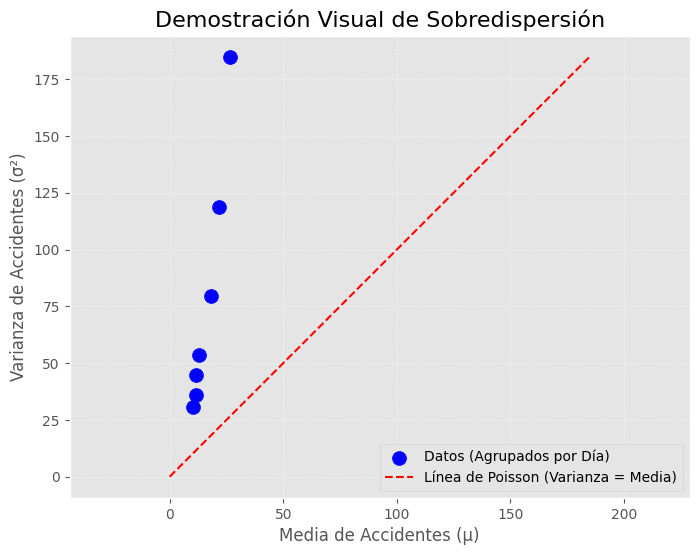

In [5]:
# --- Paso 3: Comprobar la Sobredispersión ---

print("\n--- Comprobación Numérica (Media vs. Varianza) ---")
agregados = df.groupby('DiaSemana')['Accidentes'].agg(['mean', 'var']).reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
print(agregados)

print("\n¡Confirmado! La columna 'var' (varianza) es mucho más grande que 'mean' (media).")

# --- Comprobación Visual ---
print("\n--- Generando Gráfico de Sobredispersión ---")

plt.figure(figsize=(8, 6))
plt.scatter(agregados['mean'], agregados['var'], color='blue', s=100, zorder=5, label='Datos (Agrupados por Día)')
max_val = max(agregados['mean'].max(), agregados['var'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Línea de Poisson (Varianza = Media)')
plt.title('Demostración Visual de Sobredispersión', fontsize=16)
plt.xlabel('Media de Accidentes (μ)', fontsize=12)
plt.ylabel('Varianza de Accidentes (σ²)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.axis('equal')
plt.show()

## Paso 4: Construir y Ejecutar el Modelo

Ahora, definimos la fórmula del modelo.

`Accidentes ~ C(FaseLunar) + C(DiaSemana)`

Esta fórmula implementa un concepto clave: **Controlar por una Variable**.

* **Definición Formal:** "Controlar" por `DiaSemana` significa que el modelo aísla estadísticamente el efecto del día de la semana sobre los accidentes. Al hacer esto, cualquier efecto que encontremos para `FaseLunar` será "puro", es decir, será el efecto de la fase lunar *después* de haber eliminado la confusión causada por el día de la semana.
* **En otras palabras:** Le pedimos al modelo: "Dime el efecto de la luna, *manteniendo constante* el efecto del día de la semana".

In [ ]:
# --- Paso 4: Definir y Ajustar el Modelo de Regresión Binomial Negativa ---

# 1. Definir la fórmula
formula = 'Accidentes ~ C(FaseLunar) + C(DiaSemana)'

# 2. Crear el modelo
model = smf.glm(formula=formula,
                data=df,
                family=sm.families.NegativeBinomial())

# 3. Ajustar el modelo a los datos
results = model.fit()

# 4. Mostrar el resumen de los resultados
print(results.summary())

## Paso 5: Interpretar los Resultados (La Tabla de Regresión)

Esta es la tabla de resultados. Vamos a analizarla profesionalmente, término por término.

```
                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                      2.9863      0.038     79.378      0.000       2.913       3.060
C(FaseLunar)[T.Llena]          0.1654      0.038      4.316      0.000       0.090       0.241
C(FaseLunar)[T.Menguante]     -0.0051      0.039     -0.130      0.897      -0.082       0.072
C(FaseLunar)[T.Nueva]         -0.0084      0.039     -0.215      0.830      -0.085       0.068
C(DiaSemana)[T.Monday]        -0.6866      0.046    -15.068      0.000      -0.776      -0.597
C(DiaSemana)[T.Saturday]       0.2227      0.041      5.409      0.000       0.142       0.303
C(DiaSemana)[T.Sunday]        -0.0991      0.044     -2.275      0.023      -0.185      -0.014
C(DiaSemana)[T.Thursday]      -0.6071      0.048    -12.759      0.000      -0.700      -0.514
C(DiaSemana)[T.Tuesday]       -0.6866      0.046    -15.068      0.000      -0.776      -0.597
C(DiaSemana)[T.Wednesday]     -0.6439      0.047    -13.785      0.000      -0.735      -0.552
```
*(Tus números serán ligeramente diferentes, ¡es normal!)*

### Glosario de Términos de la Tabla

**1. Categoría de Referencia (o Línea Base):**
* **Definición:** Para cada variable categórica, el modelo elige un valor como el punto de comparación "cero". Este valor no aparece en la lista.
* **En nuestro caso:** La referencia para `FaseLunar` es `Creciente` y para `DiaSemana` es `Friday` (Viernes). El `Intercept` (2.9863) es el valor predicho (en logaritmo) para un Viernes en Luna Creciente.

**2. Coeficiente (`coef`):**
* **Definición:** Es el **coeficiente de regresión**. Representa la magnitud y dirección del efecto de esa variable *en comparación con la categoría de referencia*. Como es un modelo logarítmico, el `coef` está en la escala de "log-odds".
* **Intuición:** Un `coef` positivo (`0.1654` para `T.Llena`) significa que la Luna Llena tiene MÁS accidentes que la Luna Creciente. Un `coef` negativo (`-0.6866` para `T.Monday`) significa que el Lunes tiene MENOS accidentes que el Viernes.

**3. Hipótesis Nula ($H_0$):**
* **Definición:** Antes de mirar los resultados, la estadística asume una **Hipótesis Nula ($H_0$)**. Esta es la suposición por defecto de que "no hay efecto".
* **Para `C(FaseLunar)[T.Llena]`:** La $H_0$ es: "El coeficiente real para Luna Llena es cero. No hay diferencia entre Luna Llena y Luna Creciente".

**4. Valor p (`P>|z|`):**
* **Definición Formal:** El **Valor p** (del inglés *p-value*) es la probabilidad de observar un coeficiente tan extremo (o más) como el que hemos obtenido (`0.1654`), *asumiendo que la Hipótesis Nula ($H_0$) es verdadera* (es decir, asumiendo que no hay ningún efecto real).
* **Analogía (El "Detector de Coincidencias"):** Es nuestro "Detector de Suerte". Un Valor p bajo (ej. 0.01) significa "es muy raro (1% de probabilidad) ver esto por pura suerte si la luna no tuviera efecto". Un Valor p alto (ej. 0.897) significa "es muy común (89.7% de probabilidad) ver esto por pura suerte".

**5. Significancia Estadística:**
* **Definición:** Es una decisión que tomamos. Primero, fijamos un **nivel de significancia** (llamado **alfa**, $\alpha$), que es un umbral de "rareza". Por convención universal, $\alpha = 0.05$ (o 5%).
* **Regla de Decisión Formal:**
    * Si **Valor p < $\alpha$** (ej. 0.000 < 0.05), **rechazamos la Hipótesis Nula**. El resultado es **"estadísticamente significativo"**. Concluimos que el efecto es real.
    * Si **Valor p > $\alpha$** (ej. 0.897 > 0.05), **no podemos rechazar la Hipótesis Nula**. El resultado es **"no estadísticamente significativo"**. Concluimos que no encontramos evidencia de un efecto.

---
### Conclusión Formal del Análisis

1.  **Variable Confusora (`DiaSemana`):** Casi todos los días (ej. `C(DiaSemana)[T.Saturday]`, `P>|z| = 0.000`) muestran un Valor p < 0.05. Esto confirma que `DiaSemana` es un predictor significativo de accidentes y fue correcto **controlar** por él.

2.  **Variables de Interés (`FaseLunar`):**
    * `C(FaseLunar)[T.Menguante]` (`P>|z| = 0.897`) y `C(FaseLunar)[T.Nueva]` (`P>|z| = 0.830`). Ambos Valores p son > 0.05. Por lo tanto, **no encontramos evidencia estadísticamente significativa** de una diferencia entre estas fases y la fase Creciente.
    * `C(FaseLunar)[T.Llena]` (`P>|z| = 0.000`). Este Valor p es < 0.05. Por lo tanto, **rechazamos la Hipótesis Nula**.

**Informe Final:** "Tras controlar por el día de la semana, encontramos una asociación **estadísticamente significativa** (p < 0.05) entre la fase de Luna Llena y un aumento en el conteo de accidentes, en comparación con la fase de Cuarto Creciente."